In [166]:
import cv2
import os
import numpy as np
import pandas as pd
import os
import math
import IPython, PIL
from IPython.display import Image
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Install Detectron2


In [2]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Check if it is working


In [181]:
# Inference with a keypoint detection model
im = cv2.imread("/content/drive/My Drive/Colab_Notebooks/Outputs/virtual trainer/frames/tvimg95.jpg")
im2 = cv2.imread("/content/drive/My Drive/Colab_Notebooks/datasets/tvimg7.jpg")

In [105]:
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [151]:
def draw_skeleton(im):
    outputs = predictor(im)
    points = outputs["instances"].pred_keypoints.cpu().numpy()
    points1, points2 = [], []; x, y = 0, 0
    for i in range(17):
        if i==5 or i==7 or i==9:
            x = points[0][i][0]
            y = points[0][i][1]
            cv2.circle(imcopy, (x, y), 4, (139, 0, 0), thickness=-1, lineType=cv2.FILLED)
            points2.append((x, y))
        points1.append((x, y))
    
    for i in range(2):
        cv2.line(im, points2[i], points2[i+1], (0, 255, 255), 3)
    
    return im
    

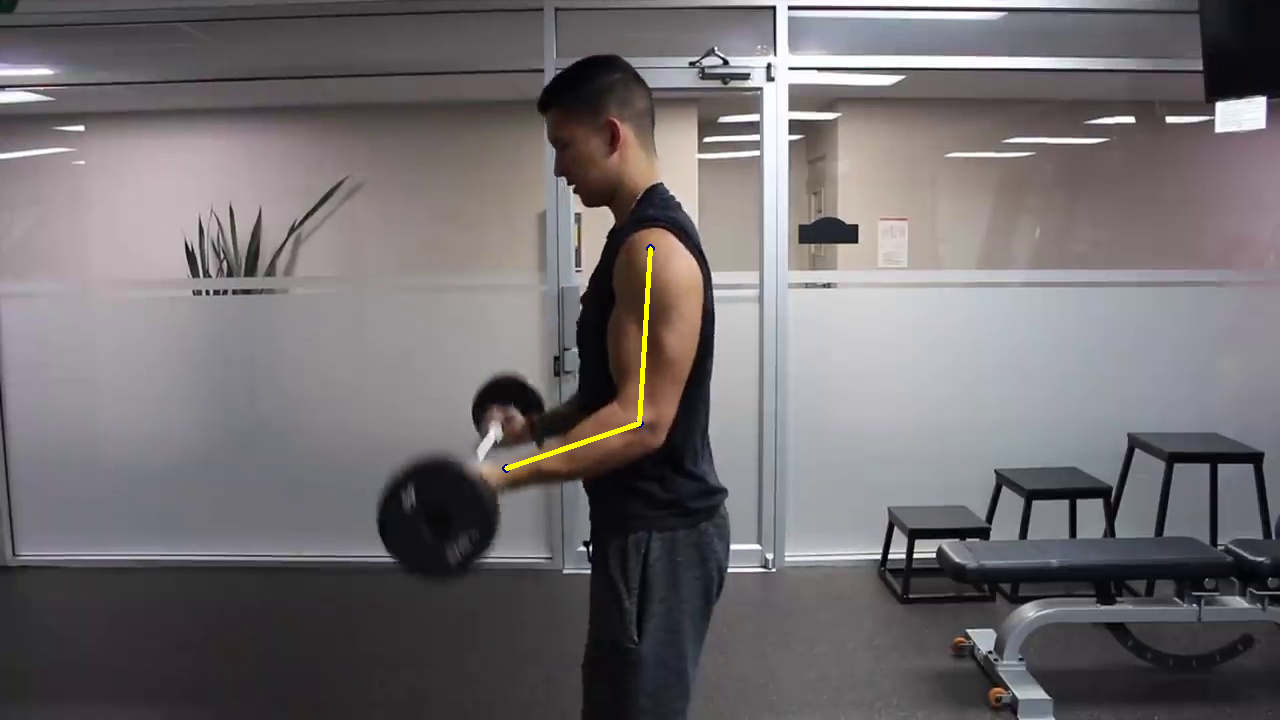

In [184]:
imcopy = np.copy(im)
skel = draw_skeleton(imcopy)
cv2_imshow(skel)

In [167]:
frames = "/content/drive/My Drive/Colab_Notebooks/Outputs/virtual trainer/frames"
processed = "/content/drive/My Drive/Colab_Notebooks/Outputs/virtual trainer/d2/frames+skel"
final = "/content/drive/My Drive/Colab_Notebooks/Outputs/virtual trainer/d2/final"
p = len(os.listdir(frames))
p

595

In [ ]:
for cnt in range(88, p):
  image_name = "tvimg{}.jpg".format(cnt)
  image_path = os.path.join(frames, image_name)
  frame = cv2.imread(image_path)
  frame = draw_skeleton(frame)
  dirr = os.path.join(processed, "skel{}.jpg".format(cnt))
  cv2.imwrite(dirr, frame)

  #print(image_name)
  if cnt%50==0:
    print("upto",image_name,"images done")

In [209]:
img_array = []
for cnt in range(88, 581) :
    image_name = "skel{}.jpg".format(cnt)
    filename = os.path.join(processed, image_name)
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img) 
    # print(image_name)
    #print(filename)
 
out = cv2.VideoWriter('weightlift_skel_d2.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)) :
    out.write(img_array[i])
out.release()
print("Done")

Done


In [146]:
def only_skeleton(image):
    lower_range = np.array([0, 0,255])  # Set the Lower range value of color in BGR
    upper_range = np.array([30,255,255])   # Set the Upper range value of color in BGR
    mask = cv2.inRange(image,lower_range,upper_range) # Create a mask with range
    thresh = cv2.bitwise_and(image,image,mask = mask)  # Performing bitwise and operation with mask in img variable

    image = thresh
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size,kernel_size),0)

    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # create a mask of the edges image using cv2.filpoly()
    mask = np.zeros_like(edges)
    ignore_mask_color = 255

    # define the Region of Interest (ROI) - source code sets as a trapezoid for roads
    imshape = image.shape

    vertices = np.array([[(imshape[0], 0),(0, 0), (0, imshape[1]),(imshape[0],imshape[1])]], dtype=np.int32)

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    return masked_edges

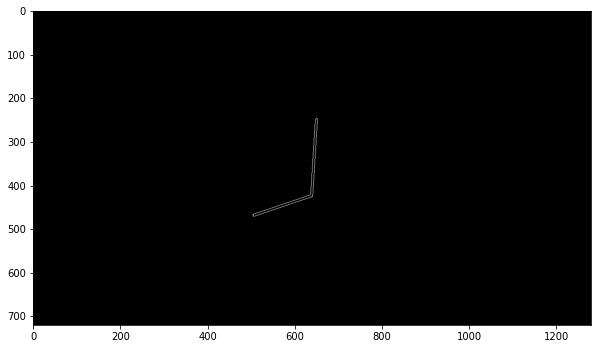

In [185]:
only_skel = only_skeleton(skel)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(only_skel, cv2.COLOR_BGR2RGB))

In [203]:
from PIL import Image
import numpy as np

def angles_count(image):
    masked_edges = only_skeleton(image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size,kernel_size),0)

    lower_range = np.array([0, 0,255])  # Set the Lower range value of color in BGR
    upper_range = np.array([30,255,255])   # Set the Upper range value of color in BGR
    mask = cv2.inRange(image,lower_range,upper_range) # Create a mask with range
    thresh = cv2.bitwise_and(image,image,mask = mask)  # Performing bitwise and operation with mask in img variable

    # define the Hough Transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 60 #minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments

    # make a blank the same size as the original image to draw on
    line_image = np.copy(image)*0 
    # IPython.display.display(PIL.Image.fromarray(line_image))

    # run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

    abs_angle1, abs_angle2, abs_angle = 0, 360, 0
    angles = []
    if lines is None:
        return None, abs_angle
    temp1, temp2 = 0, 360
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
            angle = math.atan2(x2-x1, y2-y1)
            angle = angle * 180 / 3.14

            if angle>=160:
                angle = abs(180-angle)
            
            abs_angle1 = max(temp1, abs(angle))
            abs_angle2 = min(temp2, abs(angle))
            temp1 = abs_angle1
            temp2 = abs_angle2
            angles.append(math.ceil(temp1))
            angles.append(math.ceil(temp2))

            # print(temp1, temp2)

    # draw the line on the original image

    thresh2 = Image.fromarray(thresh, 'RGB')
    # img = Image.fromarray(image, mode='L')
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    position_angle = ((int) (thresh.shape[1]/2 - 268/2 + 290), (int) (lines_edges.shape[0]/2 - 36/2 - 30))
    position_count = ((int) (thresh.shape[1]/2 - 268/2 + 290), (int) (lines_edges.shape[0]/2 - 36/2 + 60))

    if angles.count(abs_angle1)>=angles.count(abs_angle2):
        abs_angle = abs_angle1
    else:
        abs_angle = abs_angle2
    # print("Angle = ", abs_angle)
    cv2.putText(lines_edges, "Angle: {}".format(abs_angle), position_angle, cv2.FONT_HERSHEY_SIMPLEX, 1, (139, 0, 0), 2)

    return lines_edges, abs_angle

In [201]:
a, an = angles_count(skel)

In [ ]:
cv2_imshow(a)

In [205]:
# i will start taking frames from 88
start = 0; count = 0
for cnt in range(88, 581):
    image_name = "skel{}.jpg".format(cnt)
    image_path = os.path.join(processed, image_name)
    frame = cv2.imread(image_path)
    a, abs_angle = angles_count(frame)

    position_angle = ((int) (frame.shape[1]/2 - 268/2 + 290), (int) (frame.shape[0]/2 - 36/2 - 30))
    position_count = ((int) (frame.shape[1]/2 - 268/2 + 290), (int) (frame.shape[0]/2 - 36/2 + 60))

    dirr = os.path.join(final, "final{}.jpg".format(cnt))

    if a is None:
        cv2.putText(frame, "Angle: 0", position_angle, cv2.FONT_HERSHEY_SIMPLEX, 1, (139, 0, 0), 2)
        cv2.putText(frame, "{}".format(count), position_count, cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
        cv2.imwrite(dirr, frame)
        continue
    else:
        #counting
        if 7<abs_angle<10:
            start = 1
        if start==1 and float(28)<abs_angle<float(35):
            count += 1
            start = 0
    cv2.putText(a, "# {}".format(count), position_count, cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)  
    cv2.imwrite(dirr, a)
    # print(abs_angle, start, count)
        
    #print(image_name)
    if cnt%50==0:
        print("upto",image_name,"images done")

upto skel100.jpg images done
upto skel150.jpg images done
upto skel200.jpg images done
upto skel250.jpg images done
upto skel300.jpg images done
upto skel350.jpg images done
upto skel400.jpg images done
upto skel450.jpg images done
upto skel500.jpg images done
upto skel550.jpg images done


In [206]:
img_array = []
for cnt in range(88, 581) :
    image_name = "final{}.jpg".format(cnt)
    filename = os.path.join(final, image_name)
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img) 
    # print(image_name)
    #print(filename)
 
out = cv2.VideoWriter('weightlift_final2_D2.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)) :
    out.write(img_array[i])
out.release()
print("Done")

Done
